# MNIST classification example with TensorFlow

## Install packages on Google  Cloud Datalab (locally use conda env)

### Select in the Python3 Kernel:
In the menu bar the of 'Kernel', select   
**python3**
### Install needed packages
copy the command below in a Google Cloud Datalab cell  
**!pip install tensorflow==2.0.0-alpha0**
### Restart the Kernel 
this is to take into account the new installed packages. Click in the menu bar on:  
**Reset Session**

## Include paths to our functions

In [1]:
import sys
import os
import pathlib

workingdir=os.getcwd()
print(workingdir)
d=[d for d in os.listdir(workingdir)]
n=0
while not set(['notebook']).issubset(set(d)):
    workingdir=str(pathlib.Path(workingdir).parents[0])
    print(workingdir)
    d=[d for d in os.listdir(str(workingdir))]
    n+=1
    if n>5:
        break
sys.path.insert(0, workingdir)
os.chdir(workingdir)

/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/notebook/TF_2.0
/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/notebook
/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP


## Setup librairies import and plots style

### Import librairies

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from absl import logging
from absl import flags
import seaborn as sns
import numpy as np
import itertools
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from skimage.segmentation import mark_boundaries
from skimage.color import gray2rgb, rgb2gray, label2rgb
import _pickle as cPickle
import lime
from lime import lime_image
from random import sample, randint, shuffle
import time
import shutil
import glob
import re
import codecs
import json 
import subprocess
import requests
import google.auth

In [3]:
print(tf.__version__)
print(tf.keras.__version__)

2.0.0-alpha0
2.2.4-tf


### Import our utils functions

In [4]:
import src.utils.mnist_utils as mnist_utils
import src.utils.ml_utils as ml_utils
import src.utils.tensorflow_helper as tensorflow_helper
import src.model_mnist_2_0_v1.trainer.model as mnist_v1

Current Working direcotory:	/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP


In [5]:
import importlib
importlib.reload(mnist_utils)
importlib.reload(mnist_v1)
importlib.reload(ml_utils)
importlib.reload(tensorflow_helper);# to reload the function and mask the output

### Set plots style

In [6]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [7]:
# color code: https://matplotlib.org/gallery/color/named_colors.html#sphx-glr-gallery-color-named-colors-py
plt.style.use('seaborn-ticks')

## Data visualization of some examples per classes

### Loading dataset

In [8]:
path_train='data/mnist/numpy_train/'
path_test='data/mnist/numpy_test/'
x_train=cPickle.load(open(path_train+'x_train.pkl', 'rb'))
y_train=cPickle.load(open(path_train+'y_train.pkl', 'rb'))
x_test=cPickle.load(open(path_test+'x_test.pkl', 'rb'))
y_test=cPickle.load(open(path_test+'y_test.pkl', 'rb'))

### Looking at some example from training dataset

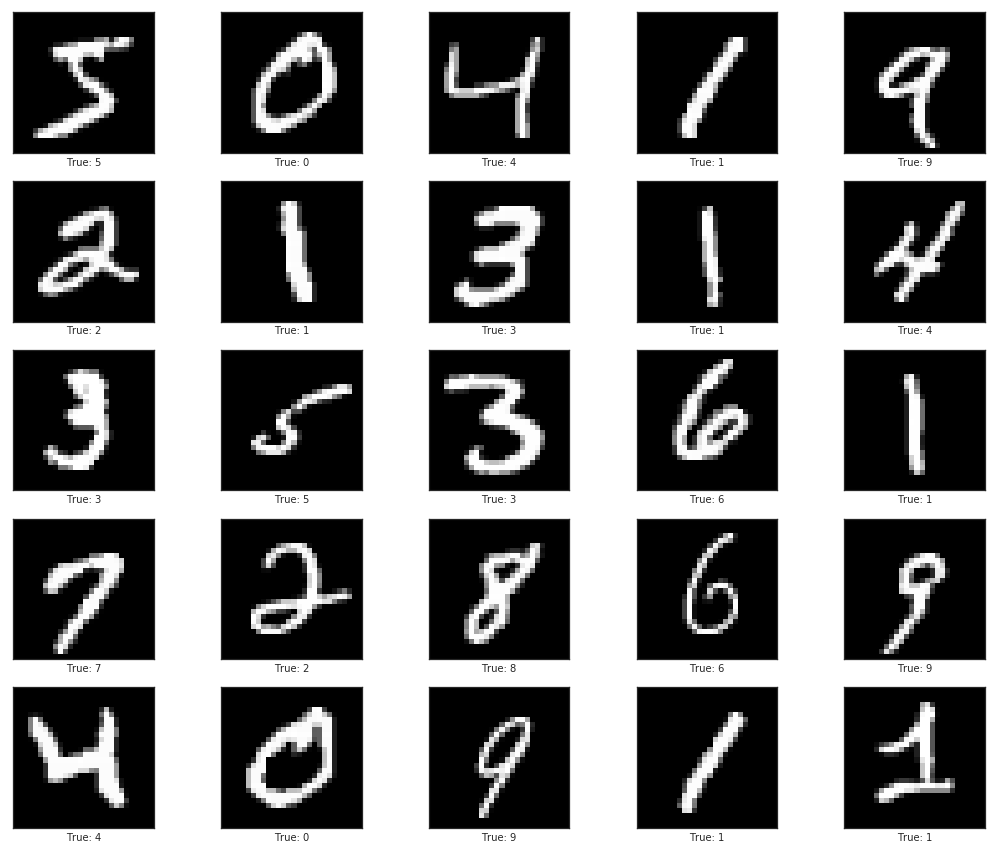

In [9]:
mnist_utils.plot_mnist_images(x_train[0:25], y_train[0:25])

## Set parameter

In [10]:
logging.set_verbosity(logging.INFO)
#logging.set_verbosity(logging.DEBUG)

In [11]:
# number of classes
NUM_CLASSES =10

# dimension of the input data
DIM_INPUT = 784

# number of epoch to train our model
EPOCHS = 100

# number of step to train our model
STEPS = 1000

# size of our mini batch
BATCH_SIZE = 128

# shuffle buffer size
SHUFFLE_BUFFER_SIZE = 10 * BATCH_SIZE

# prefetch buffer size
PREFETCH_BUFFER_SIZE = tf.data.experimental.AUTOTUNE

# number of paralell calls
NUM_PARALELL_CALL = 4

# model name
MODEL_NAME='model_mnist_v1'

# Model Version
MODEL_VERSION = 'v2'

# GCP project name, will be extracted later
PROJECT = ''

# Name of the bucket
BUCKET = 'cloud-training-demos-ml'

# GCP region
REGION = 'us-central1'

# GCP Scale Tier
TIER = 'BASIC'

# Training Directory name
TRAINING_DIR = 'mnist_trained'

# TensforFlow Version
TF_VERSION = '1.12'

# Labels
RESOURCE_LABELS='team=machine-learning,phase=test,owner=fabien'

In [12]:
os.environ['PROJECT'] = subprocess.run('gcloud config list project --format "value(core.project)"', shell=True, check=True, stdout=subprocess.PIPE).stdout.decode().replace('\n', '')
os.environ['BUCKET'] = os.environ['PROJECT']
os.environ['REGION'] = REGION
os.environ['TIER'] = TIER
os.environ['MODEL_NAME'] = MODEL_NAME
os.environ['MODEL_VERSION'] = MODEL_VERSION
os.environ['TRAINING_DIR'] = TRAINING_DIR 
os.environ['TFVERSION'] = TF_VERSION
os.environ['RESOURCE_LABELS'] = RESOURCE_LABELS

## Input dataset
Use tf.data.dataset to feed the Keras model

In [13]:
# be sure you have the tfrecords file locally if you want to train localy (or get them from Cloud Storage)
path_test_tfrecords = 'data/mnist/tfrecords_image_test/*'
path_train_tfrecords = 'data/mnist/tfrecords_image_train/*'

## Defined flags

In [14]:
print(flags.FLAGS)


absl.app:
  --[no]only_check_args: Set to true to validate args and exit.
    (default: 'false')
  --[no]pdb_post_mortem: Set to true to handle uncaught exceptions with PDB post
    mortem.
    (default: 'false')
  --profile_file: Dump profile information to a file (for python -m pstats).
    Implies --run_with_profiling.
  --[no]run_with_pdb: Set to true for PDB debug mode
    (default: 'false')
  --[no]run_with_profiling: Set to true for profiling the script. Execution will
    be slower, and the output format might change over time.
    (default: 'false')
  --[no]use_cprofile_for_profiling: Use cProfile instead of the profile module
    for profiling. This has no effect unless --run_with_profiling is set.
    (default: 'true')

absl.logging:
  --[no]alsologtostderr: also log to stderr?
    (default: 'false')
  --log_dir: directory to write logfiles into
    (default: '')
  --[no]logtostderr: Should only log to stderr?
    (default: 'false')
  --[no]showprefixforinfo: If False, do n

In [15]:
tf_flags=['f', 'input_train_tfrecords', 'input_test_tfrecords', 'model_dir', 'saved_dir', 'epoch', 'step', 'step_per_epoch', 'batch_size', 'shuffle_buffer_size', 'prefetch_buffer_size', 'num_parallel_calls', 'num_classes', 'dim_input']
tensorflow_helper.del_all_flags(flags.FLAGS, tf_flags)

In [16]:
# just for jupyter notebook and avoir : "UnrecognizedFlagError: Unknown command line flag 'f'"
flags.DEFINE_string('f', '', 'kernel') 

# path to input data
flags.DEFINE_string('input_train_tfrecords', path_train_tfrecords, 'input folder of tfrecords training data')
flags.DEFINE_string('input_test_tfrecords', path_test_tfrecords, 'input folder of tfrecords testing data')


# path to store the model and input for Tensorboard and SavedModel
flags.DEFINE_string('model_dir', 'results/Models/Mnist/tf_1_12/estimator/'+MODEL_VERSION+'/ckpt/', 'Dir to save a model and checkpoints')
flags.DEFINE_string('saved_dir', 'results/Models/Mnist/tf_1_12/estimator/'+MODEL_VERSION+'/pt/', 'Dir to save a model for TF serving')

# parameters for the input dataset and train the model
flags.DEFINE_integer('epoch', EPOCHS, 'number of epoch')
flags.DEFINE_integer('step', STEPS, 'number of step')
flags.DEFINE_integer('step_per_epoch', len(x_train) // BATCH_SIZE, 'number of step per epoch')
flags.DEFINE_integer('batch_size', BATCH_SIZE, 'Batch size')
flags.DEFINE_integer('shuffle_buffer_size', SHUFFLE_BUFFER_SIZE , 'Shuffle buffer size')
flags.DEFINE_integer('prefetch_buffer_size', PREFETCH_BUFFER_SIZE, 'Prefetch buffer size')
flags.DEFINE_integer('num_parallel_calls', NUM_PARALELL_CALL, 'Number of paralell calls')

# parameters for the model
flags.DEFINE_integer('num_classes', NUM_CLASSES, 'number of classes in our model')
flags.DEFINE_integer('dim_input', DIM_INPUT, 'dimension of the input data for our model')

FLAGS = flags.FLAGS

# new with 2.0
FLAGS(sys.argv)

['/Users/tarrade/anaconda3/envs/env_gcp_dl_2_0_alpha/lib/python3.6/site-packages/ipykernel_launcher.py']

In [17]:
print(FLAGS)


/Users/tarrade/anaconda3/envs/env_gcp_dl_2_0_alpha/lib/python3.6/site-packages/ipykernel_launcher.py:
  --batch_size: Batch size
    (default: '128')
    (an integer)
  --dim_input: dimension of the input data for our model
    (default: '784')
    (an integer)
  --epoch: number of epoch
    (default: '100')
    (an integer)
  --f: kernel
    (default: '')
  --input_test_tfrecords: input folder of tfrecords testing data
    (default: 'data/mnist/tfrecords_image_test/*')
  --input_train_tfrecords: input folder of tfrecords training data
    (default: 'data/mnist/tfrecords_image_train/*')
  --model_dir: Dir to save a model and checkpoints
    (default: 'results/Models/Mnist/tf_1_12/estimator/v2/ckpt/')
  --num_classes: number of classes in our model
    (default: '10')
    (an integer)
  --num_parallel_calls: Number of paralell calls
    (default: '4')
    (an integer)
  --prefetch_buffer_size: Prefetch buffer size
    (default: '-1')
    (an integer)
  --saved_dir: Dir to save a model 

In [18]:
# pre defined flags
tf.estimator.ModeKeys.EVAL, tf.estimator.ModeKeys.PREDICT, tf.estimator.ModeKeys.TRAIN

('eval', 'infer', 'train')

### Printing the number relater to the number of events (epoch, batch size, ...)

In [19]:
def print_summary_input(data, step='training'):
    print('Summary for the {} dataset:'.format(step))
    if step=='training':
        print('  - number of epoch            :', FLAGS.epoch)
        print('  - number of events per epoch :', len(data))
        print('  - batch size                 :', FLAGS.batch_size)
        print('  - number of step per epoch   :', FLAGS.step_per_epoch)
        print('  - total number of steps      :', FLAGS.epoch * FLAGS.step_per_epoch)
    else:
        print('  - number of epoch            :', 1)
        print('  - number of events per epoch :', len(data))
        print('  - batch size                 :', None)
        print('  - number of step per epoch   :', 1)
        print('  - total number of steps      :', 1)  

In [20]:
print_summary_input(x_train)

Summary for the training dataset:
  - number of epoch            : 100
  - number of events per epoch : 60000
  - batch size                 : 128
  - number of step per epoch   : 468
  - total number of steps      : 46800


In [21]:
print_summary_input(x_test, 'testing')

Summary for the testing dataset:
  - number of epoch            : 1
  - number of events per epoch : 10000
  - batch size                 : None
  - number of step per epoch   : 1
  - total number of steps      : 1


## Machine Learning modelling with Keras

### Deleting existing models
delete fist the folder for a clean start

In [22]:
print('trained model will be saved here:\n', FLAGS.model_dir)

trained model will be saved here:
 results/Models/Mnist/tf_1_12/estimator/v2/ckpt/


In [23]:
# deleting the folder from previous try 
shutil.rmtree(FLAGS.model_dir, ignore_errors=True)

In [24]:
print('trained model will be saved here:\n', FLAGS.saved_dir)

trained model will be saved here:
 results/Models/Mnist/tf_1_12/estimator/v2/pt/


In [25]:
# deleting the folder from previous try 
shutil.rmtree(FLAGS.saved_dir, ignore_errors=True)

### Build the model

In [26]:
# reset the model
tf.keras.backend.clear_session()

In [27]:
# build the model
model_opt_tf = mnist_v1.keras_baseline_model(FLAGS.dim_input, FLAGS.num_classes)

# store the origina weights
initial_weights = model_opt_tf.get_weights()

keras_baseline_model


### Check the nuber of parameters

In [28]:
model_opt_tf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


### Check input and output layer names

In [29]:
model_opt_tf.input_names # Use this name as the dictionary key in the TF input function

['dense_input']

In [30]:
model_opt_tf.output_names

['dense_2']

### Use tf.distribute.startegy work across multiple devices/machines

In [31]:
# the tf.distribute.Strategy API is an easy way to distribute your training across multiple devices/machines
# works
strategy=None

# TF 2.0 bug 
# https://github.com/tensorflow/tensorflow/issues/27696
#strategy = tf.distribute.MirroredStrategy()

# config tf.estimator to use a give strategy
training_config = tf.estimator.RunConfig(train_distribute=strategy,
                                         model_dir=FLAGS.model_dir,
                                         save_summary_steps=1,
                                         save_checkpoints_steps=100,
                                         keep_checkpoint_max=3,
                                         log_step_count_steps=10)

### Transform a keras model to estimator model

In [32]:
# Set to the original weights for testing other pipelines
model_opt_tf.set_weights(initial_weights)

# transfor keras model to estimator model
estimator_train_model = tf.keras.estimator.model_to_estimator(keras_model=model_opt_tf,
                                                              config=training_config)

I0410 15:19:19.377172 4586792384 keras.py:464] Using the Keras model provided.
I0410 15:19:20.087956 4586792384 estimator.py:202] Using config: {'_model_dir': 'results/Models/Mnist/tf_1_12/estimator/v2/ckpt/', '_tf_random_seed': None, '_save_summary_steps': 1, '_save_checkpoints_steps': 100, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x106d37c88>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


## Training and inference using  tf.estimator and tf.data.dataset

- **batch_size** determines the number of samples in each mini batch. Its maximum is the number of all samples, which makes gradient descent accurate, the loss will decrease towards the minimum if the learning rate is small enough, but iterations are slower. Its minimum is 1, resulting in stochastic gradient descent: Fast but the direction of the gradient step is based only on one example, the loss may jump around. batch_size allows to adjust between the two extremes: accurate gradient direction and fast iteration. Also, the maximum value for batch_size may be limited if your model + data set does not fit into the available (GPU) memory.
- **steps_per_epoch** the number of batch iterations before a training epoch is considered finished. If you have a training set of fixed size you can ignore it but it may be useful if you have a huge data set or if you are generating random data augmentations on the fly, i.e. if your training set has a (generated) infinite size. If you have the time to go through your whole training data set I recommend to skip this parameter.
- **validation_steps** similar to steps_per_epoch but on the validation data set instead on the training data. If you have the time to go through your whole validation data set I recommend to skip this parameter.



### Create some helper function

In [33]:
# need to be migrated to TF 2.0

Input dataset functions for training and testing will be pass during fit to load, convert, preprocess and reshuffle the images and labels 

### Train the  keras to estimator model locally

In [34]:
# drop all files except the keras folder before training
for x in glob.glob(FLAGS.model_dir+'*') :
    if 'keras' not in x:
        os.remove(x)

In [35]:
 for x in glob.glob(FLAGS.model_dir+'*') :
        print(x)

results/Models/Mnist/tf_1_12/estimator/v2/ckpt/keras


In [36]:
%%time
# need if file are removed with previous event files
#tf.summary.FileWriterCache.clear()

# Fit the model (using estimator.train and data.Dataset)
estimator_train_model.train(input_fn=lambda:mnist_v1.input_mnist_tfrecord_dataset_fn(path_train_tfrecords+'*',
                                                                                     FLAGS,
                                                                                     mode=tf.estimator.ModeKeys.TRAIN,
                                                                                     batch_size=FLAGS.batch_size),
                            steps=1000)

W0410 15:19:28.423527 4586792384 deprecation.py:323] From /Users/tarrade/anaconda3/envs/env_gcp_dl_2_0_alpha/lib/python3.6/site-packages/tensorflow/python/training/training_util.py:238: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
I0410 15:19:28.432069 4586792384 model.py:211] input_dataset_fn: TRAIN, train
I0410 15:19:28.639204 4586792384 estimator.py:1126] Calling model_fn.
I0410 15:19:28.938045 4586792384 estimator.py:1128] Done calling model_fn.
I0410 15:19:28.939091 4586792384 estimator.py:1332] Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='results/Models/Mnist/tf_1_12/estimator/v2/ckpt/keras/keras_model.ckpt', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
I0410 15:19:28.939711 4586792384

I0410 15:19:34.005461 4586792384 basic_session_run_hooks.py:680] global_step/sec: 82.687
I0410 15:19:34.006765 4586792384 basic_session_run_hooks.py:247] loss = 0.21281499, step = 290 (0.121 sec)
I0410 15:19:34.105813 4586792384 basic_session_run_hooks.py:594] Saving checkpoints for 300 into results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt.
W0410 15:19:34.166007 4586792384 deprecation.py:323] From /Users/tarrade/anaconda3/envs/env_gcp_dl_2_0_alpha/lib/python3.6/site-packages/tensorflow/python/training/saver.py:965: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.
I0410 15:19:34.240445 4586792384 basic_session_run_hooks.py:680] global_step/sec: 42.5577
I0410 15:19:34.241954 4586792384 basic_session_run_hooks.py:247] loss = 0.49304527, step = 300 (0.235 sec)
I0410 15:19:34.297262 4586792384 basic_session_run_hooks.py:

I0410 15:19:38.746904 4586792384 basic_session_run_hooks.py:680] global_step/sec: 80.0884
I0410 15:19:38.748486 4586792384 basic_session_run_hooks.py:247] loss = 0.07513921, step = 660 (0.125 sec)
I0410 15:19:38.884068 4586792384 basic_session_run_hooks.py:680] global_step/sec: 72.9082
I0410 15:19:38.885442 4586792384 basic_session_run_hooks.py:247] loss = 0.3393221, step = 670 (0.137 sec)
I0410 15:19:39.028126 4586792384 basic_session_run_hooks.py:680] global_step/sec: 69.4366
I0410 15:19:39.030009 4586792384 basic_session_run_hooks.py:247] loss = 0.33043787, step = 680 (0.145 sec)
I0410 15:19:39.205446 4586792384 basic_session_run_hooks.py:680] global_step/sec: 56.4621
I0410 15:19:39.208585 4586792384 basic_session_run_hooks.py:247] loss = 0.34805632, step = 690 (0.179 sec)
I0410 15:19:39.375213 4586792384 basic_session_run_hooks.py:594] Saving checkpoints for 700 into results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt.
I0410 15:19:39.532719 4586792384 basic_session_run_hooks.

CPU times: user 45.1 s, sys: 9.79 s, total: 54.9 s
Wall time: 14.8 s


In [60]:
for x in glob.glob(FLAGS.model_dir+'*') :
    print(x)

results/Models/Mnist/tf_1_12/estimator/v2/ckpt/keras
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/checkpoint
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-1000.data-00000-of-00001
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-1000.meta
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-990.index
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/graph.pbtxt
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-990.data-00000-of-00001
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-980.meta
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-990.meta
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/eval
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-980.data-00000-of-00001
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-980.index
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-1000.index


### Visualize the keras to estimator model train

In [44]:
# Load the TensorBoard notebook extension
%load_ext tensorboard.notebook
%tensorboard  --logdir   {FLAGS.model_dir}

The tensorboard.notebook extension is already loaded. To reload it, use:
  %reload_ext tensorboard.notebook


Reusing TensorBoard on port 6009 (pid 84277), started -1 day, 23:02:20 ago. (Use '!kill 84277' to kill it.)

In [39]:
# Bug TF 1.12 and TF 2.0
# Issue missing accurary for model to estimator https://github.com/tensorflow/tensorflow/issues/26804

W0410 15:22:46.074611 4586792384 event_accumulator.py:344] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0410 15:22:46.075801 4586792384 event_accumulator.py:352] Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
I0410 15:22:46.104948 4586792384 directory_watcher.py:118] No path found after results/Models/Mnist/tf_1_12/estimator/v2/ckpt/events.out.tfevents.1554902369.Fabien-Tarrades-MacBook-Pro.local
W0410 15:22:46.135484 4586792384 legend.py:1289] No handles with labels found to put in legend.




keras
checkpoint
model.ckpt-1000.data-00000-of-00001
model.ckpt-900.meta
model.ckpt-900.data-00000-of-00001
model.ckpt-1000.meta
graph.pbtxt
model.ckpt-900.index
events.out.tfevents.1554902369.Fabien-Tarrades-MacBook-Pro.local
model.ckpt-800.index
model.ckpt-800.meta
model.ckpt-1000.index
model.ckpt-800.data-00000-of-00001


dict_keys(['global_step/sec', 'loss_1'])




Loss:
  - loss [training dataset]: 0.269

Accuracy:


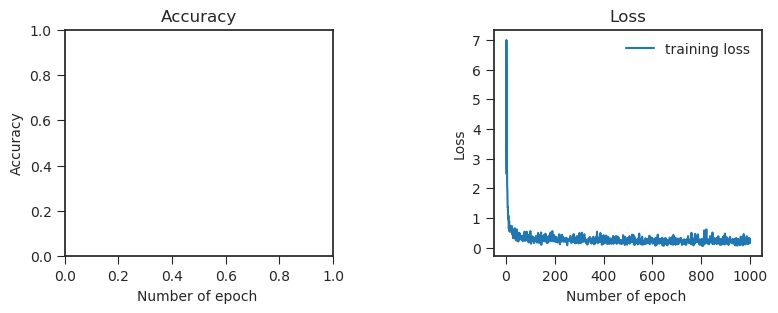

In [46]:
debug=True
history_train=ml_utils.load_data_tensorboard(FLAGS.model_dir)
if debug:
    print('\n')
    for file in glob.glob(FLAGS.model_dir+'*'):
        print(re.findall(r'[^\\/]+|[\\/]',file)[-1])
    print('\n')
    print(history_train.keys())
print('\n\n\n')
ml_utils.plot_acc_loss(history_train['loss_1'][0],history_train['loss_1'][1])

### Evaluate the  keras to estimator model locally

In [41]:
metric=estimator_train_model.evaluate(input_fn=lambda:mnist_v1.input_mnist_tfrecord_dataset_fn(path_test_tfrecords+'*',
                                                                                               FLAGS,
                                                                                               mode=tf.estimator.ModeKeys.EVAL,
                                                                                               batch_size=10000),
                                      steps=1),

I0410 14:38:08.709872 4793800128 model.py:209] input_dataset_fn: EVAL, eval
I0410 14:38:08.746841 4793800128 estimator.py:1126] Calling model_fn.
I0410 14:38:08.871615 4793800128 estimator.py:1128] Done calling model_fn.
W0410 14:38:08.872939 4793800128 deprecation.py:323] From /Users/tarrade/anaconda3/envs/env_gcp_dl_2_0_alpha/lib/python3.6/site-packages/tensorflow/python/ops/metrics_impl.py:363: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
I0410 14:38:08.903673 4793800128 evaluation.py:257] Starting evaluation at 2019-04-10T12:38:08Z
I0410 14:38:09.109874 4793800128 monitored_session.py:241] Graph was finalized.
W0410 14:38:09.111132 4793800128 deprecation.py:323] From /Users/tarrade/anaconda3/envs/env_gcp_dl_2_0_alpha/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and 

In [48]:
metric

({'accuracy': 0.9533, 'loss': 0.17182404, 'global_step': 1000},)

### Train and evaluate the  keras to estimator model locally

In [61]:
#%%time
# Delete both saved and checkpointed models
shutil.rmtree(FLAGS.model_dir, ignore_errors=True)
shutil.rmtree(FLAGS.saved_dir, ignore_errors=True)

# chcking files that are present
for x in glob.glob(FLAGS.model_dir+'*') :
    print(x)

    # need if file are removed with previous event files
#tf.summary.FileWriterCache.clear()
# Reset Keras
tf.keras.backend.clear_session()
# Fit the model (using estimator.train and data.Dataset)
mnist_v1.train_and_evaluate(FLAGS, use_keras=True)

using keras model in estimator
keras_baseline_model


I0410 21:13:47.215302 4586792384 keras.py:464] Using the Keras model provided.
I0410 21:13:48.256289 4586792384 estimator.py:202] Using config: {'_model_dir': 'results/Models/Mnist/tf_1_12/estimator/v2/ckpt/', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': 10, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 50, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c2e3105f8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
I0410 21:13:48.260534 4586792384 estima

I0410 21:13:59.723337 4586792384 evaluation.py:169] Evaluation [1/1]
I0410 21:13:59.741317 4586792384 evaluation.py:277] Finished evaluation at 2019-04-10-19:13:59
I0410 21:13:59.742007 4586792384 estimator.py:2027] Saving dict for global step 40: accuracy = 0.9054, global_step = 40, loss = 0.31584278
I0410 21:13:59.743524 4586792384 estimator.py:2087] Saving 'checkpoint_path' summary for global step 40: results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-40
I0410 21:13:59.860938 4586792384 basic_session_run_hooks.py:594] Saving checkpoints for 50 into results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt.
I0410 21:14:00.012375 4586792384 model.py:209] input_dataset_fn: EVAL, eval
I0410 21:14:00.063915 4586792384 estimator.py:1126] Calling model_fn.
I0410 21:14:00.239943 4586792384 estimator.py:1128] Done calling model_fn.
I0410 21:14:00.278999 4586792384 evaluation.py:257] Starting evaluation at 2019-04-10T19:14:00Z
I0410 21:14:00.387736 4586792384 monitored_session.py:241] 

I0410 21:14:14.812159 4586792384 estimator.py:2027] Saving dict for global step 100: accuracy = 0.9214, global_step = 100, loss = 0.26179057
I0410 21:14:14.814986 4586792384 estimator.py:2087] Saving 'checkpoint_path' summary for global step 100: results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-100
I0410 21:14:14.829656 4586792384 basic_session_run_hooks.py:680] global_step/sec: 3.92102
I0410 21:14:14.831856 4586792384 basic_session_run_hooks.py:247] loss = 0.44502282, step = 100 (12.751 sec)
I0410 21:14:14.927146 4586792384 basic_session_run_hooks.py:594] Saving checkpoints for 110 into results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt.
I0410 21:14:15.114690 4586792384 model.py:209] input_dataset_fn: EVAL, eval
I0410 21:14:15.157808 4586792384 estimator.py:1126] Calling model_fn.
I0410 21:14:15.304512 4586792384 estimator.py:1128] Done calling model_fn.
I0410 21:14:15.334676 4586792384 evaluation.py:257] Starting evaluation at 2019-04-10T19:14:15Z
I0410 21:14:15.45520

I0410 21:14:38.764381 4586792384 evaluation.py:169] Evaluation [1/1]
I0410 21:14:38.792725 4586792384 evaluation.py:277] Finished evaluation at 2019-04-10-19:14:38
I0410 21:14:38.794080 4586792384 estimator.py:2027] Saving dict for global step 160: accuracy = 0.9352, global_step = 160, loss = 0.21088217
I0410 21:14:38.795798 4586792384 estimator.py:2087] Saving 'checkpoint_path' summary for global step 160: results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-160
I0410 21:14:38.922837 4586792384 basic_session_run_hooks.py:594] Saving checkpoints for 170 into results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt.
I0410 21:14:39.072511 4586792384 model.py:209] input_dataset_fn: EVAL, eval
I0410 21:14:39.126173 4586792384 estimator.py:1126] Calling model_fn.
I0410 21:14:39.308645 4586792384 estimator.py:1128] Done calling model_fn.
I0410 21:14:39.343966 4586792384 evaluation.py:257] Starting evaluation at 2019-04-10T19:14:39Z
I0410 21:14:39.446263 4586792384 monitored_session.py:

I0410 21:14:50.890101 4586792384 evaluation.py:277] Finished evaluation at 2019-04-10-19:14:50
I0410 21:14:50.891255 4586792384 estimator.py:2027] Saving dict for global step 220: accuracy = 0.9333, global_step = 220, loss = 0.21792112
I0410 21:14:50.893166 4586792384 estimator.py:2087] Saving 'checkpoint_path' summary for global step 220: results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-220
I0410 21:14:50.995087 4586792384 basic_session_run_hooks.py:594] Saving checkpoints for 230 into results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt.
I0410 21:14:51.154728 4586792384 model.py:209] input_dataset_fn: EVAL, eval
I0410 21:14:51.203943 4586792384 estimator.py:1126] Calling model_fn.
I0410 21:14:51.363578 4586792384 estimator.py:1128] Done calling model_fn.
I0410 21:14:51.402405 4586792384 evaluation.py:257] Starting evaluation at 2019-04-10T19:14:51Z
I0410 21:14:51.512826 4586792384 monitored_session.py:241] Graph was finalized.
I0410 21:14:51.516283 4586792384 saver.py:1

I0410 21:15:03.995282 4586792384 estimator.py:2027] Saving dict for global step 280: accuracy = 0.9445, global_step = 280, loss = 0.17326953
I0410 21:15:03.997660 4586792384 estimator.py:2087] Saving 'checkpoint_path' summary for global step 280: results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-280
I0410 21:15:04.090379 4586792384 basic_session_run_hooks.py:594] Saving checkpoints for 290 into results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt.
I0410 21:15:04.282352 4586792384 model.py:209] input_dataset_fn: EVAL, eval
I0410 21:15:04.334264 4586792384 estimator.py:1126] Calling model_fn.
I0410 21:15:05.033295 4586792384 estimator.py:1128] Done calling model_fn.
I0410 21:15:05.074006 4586792384 evaluation.py:257] Starting evaluation at 2019-04-10T19:15:05Z
I0410 21:15:05.210960 4586792384 monitored_session.py:241] Graph was finalized.
I0410 21:15:05.213585 4586792384 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-290
I0

I0410 21:15:17.809108 4586792384 estimator.py:2087] Saving 'checkpoint_path' summary for global step 340: results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-340
I0410 21:15:17.962398 4586792384 basic_session_run_hooks.py:594] Saving checkpoints for 350 into results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt.
I0410 21:15:18.177236 4586792384 model.py:209] input_dataset_fn: EVAL, eval
I0410 21:15:18.247574 4586792384 estimator.py:1126] Calling model_fn.
I0410 21:15:18.451380 4586792384 estimator.py:1128] Done calling model_fn.
I0410 21:15:18.498247 4586792384 evaluation.py:257] Starting evaluation at 2019-04-10T19:15:18Z
I0410 21:15:18.627431 4586792384 monitored_session.py:241] Graph was finalized.
I0410 21:15:18.631410 4586792384 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-350
I0410 21:15:18.686575 4586792384 session_manager.py:500] Running local_init_op.
I0410 21:15:18.706825 4586792384 session_manager.py:502] Done r

I0410 21:15:31.601418 4586792384 basic_session_run_hooks.py:680] global_step/sec: 4.43365
I0410 21:15:31.605771 4586792384 basic_session_run_hooks.py:247] loss = 0.21670607, step = 400 (11.279 sec)
I0410 21:15:31.703088 4586792384 basic_session_run_hooks.py:594] Saving checkpoints for 410 into results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt.
I0410 21:15:31.933508 4586792384 model.py:209] input_dataset_fn: EVAL, eval
I0410 21:15:31.992736 4586792384 estimator.py:1126] Calling model_fn.
I0410 21:15:32.173973 4586792384 estimator.py:1128] Done calling model_fn.
I0410 21:15:32.218778 4586792384 evaluation.py:257] Starting evaluation at 2019-04-10T19:15:32Z
I0410 21:15:32.344496 4586792384 monitored_session.py:241] Graph was finalized.
I0410 21:15:32.347409 4586792384 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-410
I0410 21:15:32.384855 4586792384 session_manager.py:500] Running local_init_op.
I0410 21:15:32.399233 4586792384 

I0410 21:15:41.614373 4586792384 basic_session_run_hooks.py:594] Saving checkpoints for 470 into results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt.
I0410 21:15:41.757169 4586792384 model.py:209] input_dataset_fn: EVAL, eval
I0410 21:15:41.801161 4586792384 estimator.py:1126] Calling model_fn.
I0410 21:15:41.924087 4586792384 estimator.py:1128] Done calling model_fn.
I0410 21:15:41.952273 4586792384 evaluation.py:257] Starting evaluation at 2019-04-10T19:15:41Z
I0410 21:15:42.041178 4586792384 monitored_session.py:241] Graph was finalized.
I0410 21:15:42.043834 4586792384 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-470
I0410 21:15:42.081957 4586792384 session_manager.py:500] Running local_init_op.
I0410 21:15:42.096009 4586792384 session_manager.py:502] Done running local_init_op.
I0410 21:15:43.183619 4586792384 evaluation.py:169] Evaluation [1/1]
I0410 21:15:43.201146 4586792384 evaluation.py:277] Finished evaluation at 20

I0410 21:15:52.059013 4586792384 model.py:209] input_dataset_fn: EVAL, eval
I0410 21:15:52.101035 4586792384 estimator.py:1126] Calling model_fn.
I0410 21:15:52.239506 4586792384 estimator.py:1128] Done calling model_fn.
I0410 21:15:52.271592 4586792384 evaluation.py:257] Starting evaluation at 2019-04-10T19:15:52Z
I0410 21:15:52.364475 4586792384 monitored_session.py:241] Graph was finalized.
I0410 21:15:52.366993 4586792384 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-530
I0410 21:15:52.400753 4586792384 session_manager.py:500] Running local_init_op.
I0410 21:15:52.413256 4586792384 session_manager.py:502] Done running local_init_op.
I0410 21:15:53.644804 4586792384 evaluation.py:169] Evaluation [1/1]
I0410 21:15:53.667644 4586792384 evaluation.py:277] Finished evaluation at 2019-04-10-19:15:53
I0410 21:15:53.668538 4586792384 estimator.py:2027] Saving dict for global step 530: accuracy = 0.9556, global_step = 530, loss = 0.145058

I0410 21:16:02.977322 4586792384 estimator.py:1126] Calling model_fn.
I0410 21:16:03.105442 4586792384 estimator.py:1128] Done calling model_fn.
I0410 21:16:03.136265 4586792384 evaluation.py:257] Starting evaluation at 2019-04-10T19:16:03Z
I0410 21:16:03.222276 4586792384 monitored_session.py:241] Graph was finalized.
I0410 21:16:03.224762 4586792384 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-590
I0410 21:16:03.263946 4586792384 session_manager.py:500] Running local_init_op.
I0410 21:16:03.276329 4586792384 session_manager.py:502] Done running local_init_op.
I0410 21:16:04.523860 4586792384 evaluation.py:169] Evaluation [1/1]
I0410 21:16:04.542808 4586792384 evaluation.py:277] Finished evaluation at 2019-04-10-19:16:04
I0410 21:16:04.543829 4586792384 estimator.py:2027] Saving dict for global step 590: accuracy = 0.9512, global_step = 590, loss = 0.17064779
I0410 21:16:04.545623 4586792384 estimator.py:2087] Saving 'checkpoint_pa

I0410 21:16:13.815458 4586792384 estimator.py:1128] Done calling model_fn.
I0410 21:16:13.845441 4586792384 evaluation.py:257] Starting evaluation at 2019-04-10T19:16:13Z
I0410 21:16:13.943356 4586792384 monitored_session.py:241] Graph was finalized.
I0410 21:16:13.946246 4586792384 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-650
I0410 21:16:13.980937 4586792384 session_manager.py:500] Running local_init_op.
I0410 21:16:13.991991 4586792384 session_manager.py:502] Done running local_init_op.
I0410 21:16:15.128496 4586792384 evaluation.py:169] Evaluation [1/1]
I0410 21:16:15.143236 4586792384 evaluation.py:277] Finished evaluation at 2019-04-10-19:16:15
I0410 21:16:15.144421 4586792384 estimator.py:2027] Saving dict for global step 650: accuracy = 0.9574, global_step = 650, loss = 0.14907114
I0410 21:16:15.145715 4586792384 estimator.py:2087] Saving 'checkpoint_path' summary for global step 650: results/Models/Mnist/tf_1_12/estimato

I0410 21:16:25.150656 4586792384 model.py:209] input_dataset_fn: EVAL, eval
I0410 21:16:25.221732 4586792384 estimator.py:1126] Calling model_fn.
I0410 21:16:25.445684 4586792384 estimator.py:1128] Done calling model_fn.
I0410 21:16:25.494757 4586792384 evaluation.py:257] Starting evaluation at 2019-04-10T19:16:25Z
I0410 21:16:25.640388 4586792384 monitored_session.py:241] Graph was finalized.
I0410 21:16:25.643607 4586792384 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-710
I0410 21:16:25.719717 4586792384 session_manager.py:500] Running local_init_op.
I0410 21:16:25.739850 4586792384 session_manager.py:502] Done running local_init_op.
I0410 21:16:27.627728 4586792384 evaluation.py:169] Evaluation [1/1]
I0410 21:16:27.664256 4586792384 evaluation.py:277] Finished evaluation at 2019-04-10-19:16:27
I0410 21:16:27.666219 4586792384 estimator.py:2027] Saving dict for global step 710: accuracy = 0.9568, global_step = 710, loss = 0.153282

I0410 21:16:42.506402 4586792384 estimator.py:1126] Calling model_fn.
I0410 21:16:42.644624 4586792384 estimator.py:1128] Done calling model_fn.
I0410 21:16:42.676229 4586792384 evaluation.py:257] Starting evaluation at 2019-04-10T19:16:42Z
I0410 21:16:42.768203 4586792384 monitored_session.py:241] Graph was finalized.
I0410 21:16:42.770602 4586792384 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-770
I0410 21:16:42.805856 4586792384 session_manager.py:500] Running local_init_op.
I0410 21:16:42.817981 4586792384 session_manager.py:502] Done running local_init_op.
I0410 21:16:44.015250 4586792384 evaluation.py:169] Evaluation [1/1]
I0410 21:16:44.034198 4586792384 evaluation.py:277] Finished evaluation at 2019-04-10-19:16:44
I0410 21:16:44.034934 4586792384 estimator.py:2027] Saving dict for global step 770: accuracy = 0.949, global_step = 770, loss = 0.17242305
I0410 21:16:44.036228 4586792384 estimator.py:2087] Saving 'checkpoint_pat

I0410 21:16:56.225605 4586792384 estimator.py:1128] Done calling model_fn.
I0410 21:16:56.276108 4586792384 evaluation.py:257] Starting evaluation at 2019-04-10T19:16:56Z
I0410 21:16:56.462355 4586792384 monitored_session.py:241] Graph was finalized.
I0410 21:16:56.465896 4586792384 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-830
I0410 21:16:56.509362 4586792384 session_manager.py:500] Running local_init_op.
I0410 21:16:56.527706 4586792384 session_manager.py:502] Done running local_init_op.
I0410 21:16:58.339236 4586792384 evaluation.py:169] Evaluation [1/1]
I0410 21:16:58.359535 4586792384 evaluation.py:277] Finished evaluation at 2019-04-10-19:16:58
I0410 21:16:58.360578 4586792384 estimator.py:2027] Saving dict for global step 830: accuracy = 0.9551, global_step = 830, loss = 0.15452981
I0410 21:16:58.362634 4586792384 estimator.py:2087] Saving 'checkpoint_path' summary for global step 830: results/Models/Mnist/tf_1_12/estimato

I0410 21:17:16.199608 4586792384 evaluation.py:257] Starting evaluation at 2019-04-10T19:17:16Z
I0410 21:17:16.340945 4586792384 monitored_session.py:241] Graph was finalized.
I0410 21:17:16.345278 4586792384 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-890
I0410 21:17:16.392704 4586792384 session_manager.py:500] Running local_init_op.
I0410 21:17:16.407267 4586792384 session_manager.py:502] Done running local_init_op.
I0410 21:17:18.995966 4586792384 evaluation.py:169] Evaluation [1/1]
I0410 21:17:19.038729 4586792384 evaluation.py:277] Finished evaluation at 2019-04-10-19:17:19
I0410 21:17:19.041464 4586792384 estimator.py:2027] Saving dict for global step 890: accuracy = 0.955, global_step = 890, loss = 0.17467879
I0410 21:17:19.044250 4586792384 estimator.py:2087] Saving 'checkpoint_path' summary for global step 890: results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-890
I0410 21:17:19.229586 4586792384 basic_session_run_

I0410 21:17:32.426012 4586792384 monitored_session.py:241] Graph was finalized.
I0410 21:17:32.428411 4586792384 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-950
I0410 21:17:32.466597 4586792384 session_manager.py:500] Running local_init_op.
I0410 21:17:32.481749 4586792384 session_manager.py:502] Done running local_init_op.
I0410 21:17:34.299776 4586792384 evaluation.py:169] Evaluation [1/1]
I0410 21:17:34.332722 4586792384 evaluation.py:277] Finished evaluation at 2019-04-10-19:17:34
I0410 21:17:34.334562 4586792384 estimator.py:2027] Saving dict for global step 950: accuracy = 0.9564, global_step = 950, loss = 0.16327454
I0410 21:17:34.338106 4586792384 estimator.py:2087] Saving 'checkpoint_path' summary for global step 950: results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-950
I0410 21:17:34.362948 4586792384 basic_session_run_hooks.py:680] global_step/sec: 4.09327
I0410 21:17:34.366499 4586792384 basic_session_run_hooks

In [62]:
# checking files that are present
for x in glob.glob(FLAGS.model_dir+'*') :
    print(x)

results/Models/Mnist/tf_1_12/estimator/v2/ckpt/keras
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/checkpoint
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-1000.data-00000-of-00001
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-1000.meta
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-990.index
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/graph.pbtxt
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-990.data-00000-of-00001
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-980.meta
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-990.meta
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-980.data-00000-of-00001
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-980.index
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-1000.index


### Visualize the keras to estimator model train/eval

In [63]:
# Load the TensorBoard notebook extension
%load_ext tensorboard.notebook
%tensorboard  --logdir   {FLAGS.model_dir}

The tensorboard.notebook extension is already loaded. To reload it, use:
  %reload_ext tensorboard.notebook


Reusing TensorBoard on port 6009 (pid 84277), started 5:01:40 ago. (Use '!kill 84277' to kill it.)

I0410 15:33:33.353913 4586792384 directory_watcher.py:118] No path found after results/Models/Mnist/tf_1_12/estimator/v2/ckpt//eval/events.out.tfevents.1554902658.Fabien-Tarrades-MacBook-Pro.local




keras
checkpoint
model.ckpt-1000.data-00000-of-00001
model.ckpt-1000.meta
model.ckpt-990.index
graph.pbtxt
model.ckpt-990.data-00000-of-00001
model.ckpt-980.meta
model.ckpt-990.meta
eval
model.ckpt-980.data-00000-of-00001
model.ckpt-980.index
model.ckpt-1000.index


dict_keys(['accuracy', 'loss'])
number of entry for eval: 100




Loss:
  - loss [validation dataset: 0.145

Accuracy:
  - accuracy [validation dataset: 95.82%


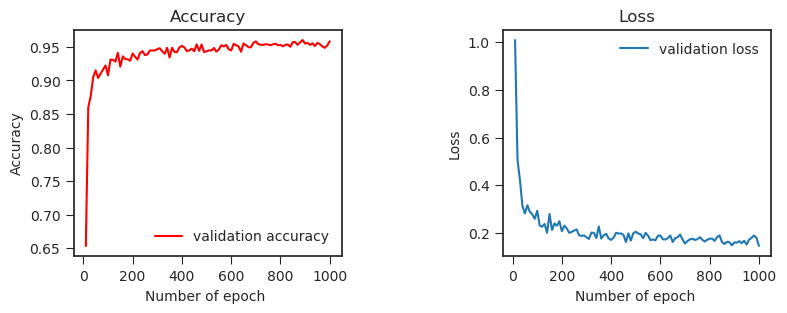

In [59]:
debug=True
#history_train=ml_utils.load_data_tensorboard(FLAGS.model_dir)
history_eval=ml_utils.load_data_tensorboard(FLAGS.model_dir+'/eval')
if debug:
    print('\n')
    for file in glob.glob(FLAGS.model_dir+'*'):
        print(re.findall(r'[^\\/]+|[\\/]',file)[-1])
    print('\n')
    #print(history_train.keys())
    print(history_eval.keys())
    #print('number of entry for train:', len(history_train['loss_1']))
    print('number of entry for eval:', len(history_eval['loss'][0]))
print('\n\n\n')
ml_utils.plot_acc_loss(None, None,
                       None, None,
                       history_eval['loss'][0],history_eval['loss'][1],
                       history_eval['accuracy'][0],history_eval['accuracy'][1])

### Predict using the  keras to estimator model locally

### Train and evaluate the estimator model with keras layers locally

In [ ]:
Tensor("IteratorGetNext:1", shape=(128, 10), dtype=float32, device=/job:localhost/replica:0/task:0/device:CPU:0)
Tensor("sequential/dense_2/Softmax:0", shape=(128, 10), dtype=float32, device=/job:localhost/replica:0/task:0/device:CPU:0)
loss Tensor("softmax_cross_entropy_loss/value:0", shape=(), dtype=float32, device=/job:localhost/replica:0/task:0/device:CPU:0)

In [188]:
%%time
# Bug TF 2.0
# comment out exporter because of thie issue https://github.com/tensorflow/tensorflow/issues/27345

logging.set_verbosity(logging.INFO)
# Delete both saved and checkpointed models
shutil.rmtree(FLAGS.model_dir, ignore_errors=True)
shutil.rmtree(FLAGS.saved_dir, ignore_errors=True)
for x in glob.glob(FLAGS.model_dir+'*') :
    print(x)
# need if file are removed with previous event files
#tf.summary.FileWriterCache.clear()
# Reset Keras
tf.keras.backend.clear_session()
# Fit the model (using estimator.train and data.Dataset)
mnist_v1.train_and_evaluate(FLAGS, use_keras=False)
logging.set_verbosity(logging.INFO)

W0409 15:16:08.240805 4543133120 cross_device_ops.py:1111] Not all devices in `tf.distribute.Strategy` are visible to TensorFlow.
I0409 15:16:08.245428 4543133120 run_config.py:532] Initializing RunConfig with distribution strategies.
I0409 15:16:08.246266 4543133120 estimator_training.py:167] Not using Distribute Coordinator.
I0409 15:16:08.256110 4543133120 estimator.py:202] Using config: {'_model_dir': 'results/Models/Mnist/tf_1_12/estimator/ckpt/', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': 10, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 50, '_train_distribute': <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x1c5c0a3160>, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': No

using keras layer and estimator (recommended way)


I0409 15:16:08.480813 123145627303936 estimator.py:1126] Calling model_fn.


model based on keras layer but return an estimator model


I0409 15:16:08.767280 123145627303936 coordinator.py:219] Error reported to Coordinator: 'Tensor' object is not callable
Traceback (most recent call last):
  File "/Users/tarrade/anaconda3/envs/env_gcp_dl_2_0_alpha/lib/python3.6/site-packages/tensorflow/python/training/coordinator.py", line 297, in stop_on_exception
    yield
  File "/Users/tarrade/anaconda3/envs/env_gcp_dl_2_0_alpha/lib/python3.6/site-packages/tensorflow/python/distribute/mirrored_strategy.py", line 882, in run
    self.main_result = self.main_fn(*self.main_args, **self.main_kwargs)
  File "/Users/tarrade/anaconda3/envs/env_gcp_dl_2_0_alpha/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1127, in _call_model_fn
    model_fn_results = self._model_fn(features=features, **kwargs)
  File "/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/src/model_mnist_2_0_v1/trainer/model.py", line 470, in baseline_estimator_model
    train_op = op

Tensor("Identity_7:0", shape=(), dtype=float32)
step 6
step 7


TypeError: 'Tensor' object is not callable

In [155]:
!ls -la results/Models/Mnist/tf_1_12/estimator/ckpt/

total 49200
drwxr-xr-x  13 tarrade  staff      416 Apr  8 22:10 .
drwxr-xr-x   4 tarrade  staff      128 Apr  8 22:06 ..
-rw-r--r--   1 tarrade  staff      177 Apr  8 22:10 checkpoint
-rw-r--r--   1 tarrade  staff   436513 Apr  8 22:06 graph.pbtxt
-rw-r--r--   1 tarrade  staff  8036488 Apr  8 22:10 model.ckpt-1000.data-00000-of-00001
-rw-r--r--   1 tarrade  staff      765 Apr  8 22:10 model.ckpt-1000.index
-rw-r--r--   1 tarrade  staff   201552 Apr  8 22:10 model.ckpt-1000.meta
-rw-r--r--   1 tarrade  staff  8036488 Apr  8 22:10 model.ckpt-980.data-00000-of-00001
-rw-r--r--   1 tarrade  staff      765 Apr  8 22:10 model.ckpt-980.index
-rw-r--r--   1 tarrade  staff   201552 Apr  8 22:10 model.ckpt-980.meta
-rw-r--r--   1 tarrade  staff  8036488 Apr  8 22:10 model.ckpt-990.data-00000-of-00001
-rw-r--r--   1 tarrade  staff      765 Apr  8 22:10 model.ckpt-990.index
-rw-r--r--   1 tarrade  staff   201552 Apr  8 22:10 model.ckpt-990.meta


### Visualize the estimator model with keras layers locally

In [113]:
debug=True
history_train=ml_utils.load_data_tensorboard(FLAGS.model_dir)
history_eval=ml_utils.load_data_tensorboard(FLAGS.model_dir)
if debug:
    print('\n')
    for file in glob.glob(FLAGS.model_dir+'*'):
        print(re.findall(r'[^\\/]+|[\\/]',file)[-1])
    print('\n')
    print(history_train.keys())
    print(history_eval.keys())
    print('number of entry for train:', len(history_train['loss'][0]))
    print('number of entry for eval:', len(history_eval['loss'][0]))
print('\n\n\n')
ml_utils.plot_acc_loss(history_train['loss'][0],history_train['loss'][1],
                       history_train['accuracy_1'][0],history_train['accuracy_1'][1],
                       history_eval['loss'][0],history_eval['loss'][1],
                       history_eval['accuracy'][0],history_eval['accuracy'][1])



checkpoint
model.ckpt-1000.data-00000-of-00001
model.ckpt-1000.meta
model.ckpt-990.index
graph.pbtxt
model.ckpt-990.data-00000-of-00001
model.ckpt-980.meta
model.ckpt-990.meta
model.ckpt-980.data-00000-of-00001
model.ckpt-980.index
model.ckpt-1000.index


dict_keys([])
dict_keys([])


KeyError: 'loss'

### Train and evaluate the estimator model with keras layers locally with python
do a small test locally to check that the python package is working

In [103]:
%%bash
# Setup python so it sees the task module which controls the model.py
export PYTHONPATH=${PYTHONPATH}:${PWD}/src/model_mnist_v1
python -m trainer.task \
--epoch=2 \
--step_per_epoch=468 \
--input_test_tfrecords='data/mnist/tfrecords_image_test/*' \
--input_train_tfrecords='data/mnist/tfrecords_image_train/*' \
--model_dir='results/Models/Mnist/tf_1_12/estimator/ckpt/' \
--saved_dir='results/Models/Mnist/tf_1_12/estimator/pt/' 

exporter <tensorflow.python.estimator.exporter.LatestExporter object at 0x1c39505898>
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 

INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Using config: {'_model_dir': 'results/Models/Mnist/tf_1_12/estimator/ckpt/', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': 10, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 50, '_train_distribute': <tensorflow.contrib.distribute.python.one_device_strategy.OneDeviceStrategy object at 0x1c39505be0>, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c39505da0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief'

DEBUG:tensorflow:Opening a record reader pointing at results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553682141.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Loading events from results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553682141.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Cannot read more events: Read less bytes than requested
DEBUG:tensorflow:No more events in results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553682141.Fabien-Tarrades-MacBook-Pro.local
INFO:tensorflow:No path found after results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553682141.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Opening a record reader pointing at results/Models/Mnist/tf_1_12/estimator/ckpt//eval/events.out.tfevents.1553682145.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Loading events from results/Models/Mnist/tf_1_12/estimator/ckpt//eval/events.out.tfevents.1553682145.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tens

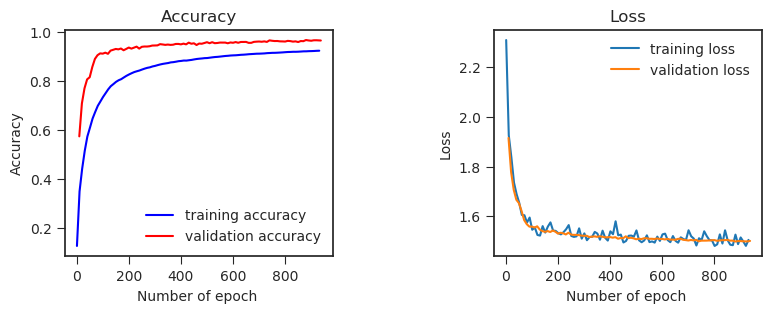

In [104]:
debug=True
history_train=ml_utils.load_data_tensorboard(FLAGS.model_dir)
history_eval=ml_utils.load_data_tensorboard(FLAGS.model_dir+'/eval')
if debug:
    print('\n')
    for file in glob.glob(FLAGS.model_dir+'*'):
        print(re.findall(r'[^\\/]+|[\\/]',file)[-1])
    print('\n')
    print(history_train.keys())
    print(history_eval.keys())
    print('number of entry for train:', len(history_train['loss'][0]))
    print('number of entry for eval:', len(history_eval['loss'][0]))
print('\n\n\n')
ml_utils.plot_acc_loss(history_train['loss'][0],history_train['loss'][1],
                       history_train['accuracy_1'][0],history_train['accuracy_1'][1],
                       history_eval['loss'][0],history_eval['loss'][1],
                       history_eval['accuracy'][0],history_eval['accuracy'][1])

### Train the model on locally using gcloud

In [109]:
%%bash
# Use Cloud Machine Learning Engine to train the model in local file system
gcloud ml-engine local train \
   --module-name=trainer.task \
   --package-path=${PWD}/src/${MODEL_NAME}/trainer \
   -- \
   --epoch=2 \
   --step_per_epoch=468 \
   --input_test_tfrecords=${PWD}/'data/mnist/tfrecords_image_test/*' \
   --input_train_tfrecords=${PWD}/'data/mnist/tfrecords_image_train/*' \
   --model_dir=${PWD}/'results/Models/Mnist/tf_1_12/estimator/ckpt/' \
   --saved_dir=${PWD}/'results/Models/Mnist/tf_1_12/estimator/pt/' 

exporter <tensorflow.python.estimator.exporter.LatestExporter object at 0x1c32505668>
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 

INFO:tensorflow:TF_CONFIG environment variable: {'environment': 'cloud', 'cluster': {}, 'job': {'args': ['--epoch=2', '--step_per_epoch=468', '--input_test_tfrecords=/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/data/mnist/tfrecords_image_test/*', '--input_train_tfrecords=/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/data/mnist/tfrecords_image_train/*', '--model_dir=/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/results/Models/Mnist/tf_1_12/estimator/ckpt/', '--saved_dir=/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/results/Models/Mnist/tf_1_12/estimator/pt/'], 'job_name': 'trainer.task'}, 'task': {}}
INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:RunConfig initialized for Distribute Coordinator with INDEPENDENT_WORKER mode
INFO:

DEBUG:tensorflow:Opening a record reader pointing at results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553686740.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Loading events from results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553686740.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Cannot read more events: Read less bytes than requested
DEBUG:tensorflow:No more events in results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553686740.Fabien-Tarrades-MacBook-Pro.local
INFO:tensorflow:No path found after results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553686740.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Opening a record reader pointing at results/Models/Mnist/tf_1_12/estimator/ckpt//eval/events.out.tfevents.1553686744.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Loading events from results/Models/Mnist/tf_1_12/estimator/ckpt//eval/events.out.tfevents.1553686744.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tens

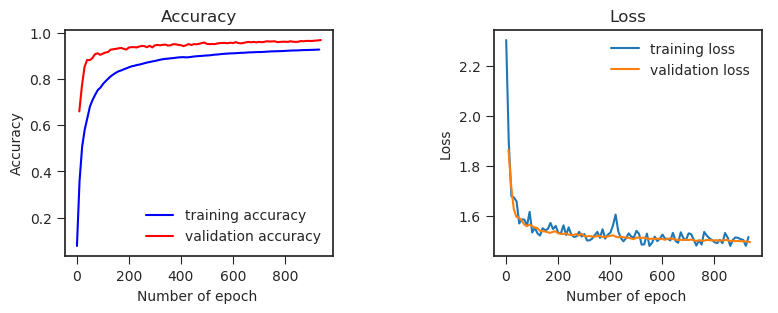

In [110]:
debug=True
history_train=ml_utils.load_data_tensorboard(FLAGS.model_dir)
history_eval=ml_utils.load_data_tensorboard(FLAGS.model_dir+'/eval')
if debug:
    print('\n')
    for file in glob.glob(FLAGS.model_dir+'*'):
        print(re.findall(r'[^\\/]+|[\\/]',file)[-1])
    print('\n')
    print(history_train.keys())
    print(history_eval.keys())
    print('number of entry for train:', len(history_train['loss'][0]))
    print('number of entry for eval:', len(history_eval['loss'][0]))
print('\n\n\n')
ml_utils.plot_acc_loss(history_train['loss'][0],history_train['loss'][1],
                       history_train['accuracy_1'][0],history_train['accuracy_1'][1],
                       history_eval['loss'][0],history_eval['loss'][1],
                       history_eval['accuracy'][0],history_eval['accuracy'][1])

### Train the model on GCP using gcloud

In [630]:
!gsutil ls gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/

gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-1.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-10.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-2.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-3.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-4.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-5.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-6.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-7.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-8.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-9.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/tfrecord_image_test/
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/tfrecords_image_test/


In [111]:
!pwd

/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP


In [653]:
%%bash
echo "gs://${PROJECT}/mnist/tfrecords/image_test/"

gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/


In [658]:
%%bash
# Clear Cloud Storage bucket and copy the tfrecords files to Cloud Storage bucket
echo $BUCKET
gsutil -m rm -rf "gs://${BUCKET}/mnist/tfrecords/image_test/"
gsutil -m rm -rf "gs://${BUCKET}/mnist/tfrecords/image_train/"
gsutil -m cp "${PWD}/data/mnist/tfrecords_image_test/*" "gs://${BUCKET}/mnist/tfrecords/image_test/"
gsutil -m cp "${PWD}/data/mnist/tfrecords_image_train/*" "gs://${BUCKET}/mnist/tfrecords/image_train/"

ml-productive-pipeline-53122


Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-1.tfrecords#1553517828053883...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-10.tfrecords#1553517828015615...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-2.tfrecords#1553517827285785...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-3.tfrecords#1553517827539125...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-4.tfrecords#1553517828118894...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-5.tfrecords#1553517827486017...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-6.tfrecords#1553517827901783...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-7.tfrecords#1553517828044041...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-8.tfrecords#1553517827140683...
Removing gs://ml-productive-pipeline

In [696]:
%%bash
OUTDIR="gs://${BUCKET}/${MODEL_NAME}/${TRAINING_DIR}"
JOBNAME=${MODEL_NAME}_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
# Clear the Cloud Storage Bucket used for the training job
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=${PWD}/src/${MODEL_NAME}/trainer \
   --job-dir=$OUTDIR \
   --staging-bucket="gs://$BUCKET" \
   --scale-tier=$TIER \
   --runtime-version=$TFVERSION \
   --python-version='3.5' \
   --labels=$RESOURCE_LABELS \
   -- \
   --epoch=2 \
   --step_per_epoch=468 \
   --input_test_tfrecords= "gs://${BUCKET}/mnist/tfrecords/image_test/*" \
   --input_train_tfrecords="gs://${BUCKET}/mnist/tfrecords/image_train/*" \
   --model_dir=$OUTDIR \
   --saved_dir=$OUTDIR   

gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained us-central1 model_mnist_v1_190325_152158
jobId: model_mnist_v1_190325_152158
state: QUEUED


CommandException: 1 files/objects could not be removed.
Job [model_mnist_v1_190325_152158] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe model_mnist_v1_190325_152158

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs model_mnist_v1_190325_152158


In [697]:
! gcloud ml-engine jobs stream-logs model_mnist_v1_190325_152158

INFO	2019-03-25 16:22:04 +0100	service		Validating job requirements...
INFO	2019-03-25 16:22:04 +0100	service		Job creation request has been successfully validated.
INFO	2019-03-25 16:22:05 +0100	service		Job model_mnist_v1_190325_152158 is queued.
INFO	2019-03-25 16:22:05 +0100	service		Waiting for job to be provisioned.
INFO	2019-03-25 16:22:08 +0100	service		Waiting for training program to start.
INFO	2019-03-25 16:23:44 +0100	master-replica-0		Running task with arguments: --cluster={"master": ["127.0.0.1:2222"]} --task={"type": "master", "index": 0} --job={  "package_uris": ["gs://ml-productive-pipeline-53122/model_mnist_v1_190325_152158/c22fca2b0adcf8de1bb4a11353a9ac9cc2f655f4d527462ea4346efc2e3e7a11/model_mnist_v1-0.1.tar.gz"],  "python_module": "trainer.task",  "args": ["--epoch\u003d2", "--step_per_epoch\u003d468", "--input_test_tfrecords\u003d", "gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/*", "--input_train_tfrecords\u003dgs://ml-productive-pipeline-53122/mni

INFO	2019-03-25 16:24:28 +0100	master-replica-0		TF_CONFIG environment variable: {'task': {'cloud': 'qe913eccfb8ab063b-ml', 'index': 0, 'type': 'master'}, 'cluster': {'master': ['127.0.0.1:2222']}, 'environment': 'cloud', 'job': {'runtime_version': '1.12', 'python_module': 'trainer.task', 'package_uris': ['gs://ml-productive-pipeline-53122/model_mnist_v1_190325_152158/c22fca2b0adcf8de1bb4a11353a9ac9cc2f655f4d527462ea4346efc2e3e7a11/model_mnist_v1-0.1.tar.gz'], 'python_version': '3.5', 'job_dir': 'gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained', 'region': 'us-central1', 'run_on_raw_vm': True, 'args': ['--epoch=2', '--step_per_epoch=468', '--input_test_tfrecords=', 'gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/*', '--input_train_tfrecords=gs://ml-productive-pipeline-53122/mnist/tfrecords/image_train/*', '--model_dir=gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained', '--saved_dir=gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained',

INFO	2019-03-25 16:25:09 +0100	master-replica-0		Assets added to graph.
INFO	2019-03-25 16:25:09 +0100	master-replica-0		No assets to write.
INFO	2019-03-25 16:25:15 +0100	master-replica-0		SavedModel written to: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/export/exporter/temp-b'1553527507'/saved_model.pb
INFO	2019-03-25 16:25:19 +0100	master-replica-0		Saving checkpoints for 40 into gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt.
INFO	2019-03-25 16:25:26 +0100	master-replica-0		input_dataset_fn: EVAL, eval
INFO	2019-03-25 16:25:26 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:25:26 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:25:26 +0100	master-replica-0		Starting evaluation at 2019-03-25-15:25:26
INFO	2019-03-25 16:25:26 +0100	master-replica-0		Graph was finalized.
INFO	2019-03-25 16:25:26 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/mo

INFO	2019-03-25 16:26:26 +0100	master-replica-0		Signatures INCLUDED in export for Regress: None
INFO	2019-03-25 16:26:26 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-100
INFO	2019-03-25 16:26:26 +0100	master-replica-0		Assets added to graph.
INFO	2019-03-25 16:26:26 +0100	master-replica-0		No assets to write.
INFO	2019-03-25 16:26:31 +0100	master-replica-0		SavedModel written to: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/export/exporter/temp-b'1553527585'/saved_model.pb
INFO	2019-03-25 16:26:34 +0100	master-replica-0		global_step/sec: 1.00519
INFO	2019-03-25 16:26:34 +0100	master-replica-0		loss = 0.31793758, step = 100 (99.484 sec)
INFO	2019-03-25 16:26:34 +0100	master-replica-0		Saving checkpoints for 120 into gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt.
INFO	2019-03-25 16:26:41 +0100	master-replica-0		input_dataset_fn: EVAL, eval
INFO	2019-03-25 16:26:41

INFO	2019-03-25 16:27:40 +0100	master-replica-0		Signatures INCLUDED in export for Eval: None
INFO	2019-03-25 16:27:40 +0100	master-replica-0		Signatures INCLUDED in export for Predict: ['serving_default']
INFO	2019-03-25 16:27:40 +0100	master-replica-0		Signatures INCLUDED in export for Classify: None
INFO	2019-03-25 16:27:40 +0100	master-replica-0		Signatures INCLUDED in export for Train: None
INFO	2019-03-25 16:27:40 +0100	master-replica-0		Signatures INCLUDED in export for Regress: None
INFO	2019-03-25 16:27:40 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-180
INFO	2019-03-25 16:27:40 +0100	master-replica-0		Assets added to graph.
INFO	2019-03-25 16:27:40 +0100	master-replica-0		No assets to write.
INFO	2019-03-25 16:27:45 +0100	master-replica-0		SavedModel written to: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/export/exporter/temp-b'1553527658'/saved_model.pb
INFO	2019-03-25 16:27:48 

INFO	2019-03-25 16:28:46 +0100	master-replica-0		Starting evaluation at 2019-03-25-15:28:46
INFO	2019-03-25 16:28:46 +0100	master-replica-0		Graph was finalized.
INFO	2019-03-25 16:28:46 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-260
INFO	2019-03-25 16:28:47 +0100	master-replica-0		Running local_init_op.
INFO	2019-03-25 16:28:47 +0100	master-replica-0		Done running local_init_op.
INFO	2019-03-25 16:28:47 +0100	master-replica-0		Finished evaluation at 2019-03-25-15:28:47
INFO	2019-03-25 16:28:47 +0100	master-replica-0		Saving dict for global step 260: accuracy = 0.0, global_step = 260, loss = 0.0
INFO	2019-03-25 16:28:47 +0100	master-replica-0		Saving 'checkpoint_path' summary for global step 260: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-260
INFO	2019-03-25 16:28:48 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:28:48 +0100	master-replica-0		Done calling model_

INFO	2019-03-25 16:29:54 +0100	master-replica-0		Done running local_init_op.
INFO	2019-03-25 16:29:54 +0100	master-replica-0		Finished evaluation at 2019-03-25-15:29:54
INFO	2019-03-25 16:29:54 +0100	master-replica-0		Saving dict for global step 340: accuracy = 0.0, global_step = 340, loss = 0.0
INFO	2019-03-25 16:29:54 +0100	master-replica-0		Saving 'checkpoint_path' summary for global step 340: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-340
INFO	2019-03-25 16:29:55 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:29:55 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:29:55 +0100	master-replica-0		Signatures INCLUDED in export for Eval: None
INFO	2019-03-25 16:29:55 +0100	master-replica-0		Signatures INCLUDED in export for Predict: ['serving_default']
INFO	2019-03-25 16:29:55 +0100	master-replica-0		Signatures INCLUDED in export for Classify: None
INFO	2019-03-25 16:29:55 +0100	master-replica-0		Signatures INCLUDED in export 

INFO	2019-03-25 16:30:48 +0100	master-replica-0		SavedModel written to: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/export/exporter/temp-b'1553527844'/saved_model.pb
INFO	2019-03-25 16:30:51 +0100	master-replica-0		global_step/sec: 1.22815
INFO	2019-03-25 16:30:51 +0100	master-replica-0		loss = 0.047065996, step = 400 (81.423 sec)
INFO	2019-03-25 16:30:51 +0100	master-replica-0		Saving checkpoints for 420 into gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt.
INFO	2019-03-25 16:30:57 +0100	master-replica-0		input_dataset_fn: EVAL, eval
INFO	2019-03-25 16:30:57 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:30:57 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:30:57 +0100	master-replica-0		Starting evaluation at 2019-03-25-15:30:57
INFO	2019-03-25 16:30:58 +0100	master-replica-0		Graph was finalized.
INFO	2019-03-25 16:30:58 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/mode

INFO	2019-03-25 16:31:54 +0100	master-replica-0		Saving checkpoints for 500 into gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt.
INFO	2019-03-25 16:32:00 +0100	master-replica-0		input_dataset_fn: EVAL, eval
INFO	2019-03-25 16:32:01 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:32:01 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:32:01 +0100	master-replica-0		Starting evaluation at 2019-03-25-15:32:01
INFO	2019-03-25 16:32:01 +0100	master-replica-0		Graph was finalized.
INFO	2019-03-25 16:32:01 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-500
INFO	2019-03-25 16:32:01 +0100	master-replica-0		Running local_init_op.
INFO	2019-03-25 16:32:01 +0100	master-replica-0		Done running local_init_op.
INFO	2019-03-25 16:32:02 +0100	master-replica-0		Finished evaluation at 2019-03-25-15:32:02
INFO	2019-03-25 16:32:02 +0100	master-replica-0		Saving dict for global

INFO	2019-03-25 16:32:49 +0100	master-replica-0		No assets to write.
INFO	2019-03-25 16:32:53 +0100	master-replica-0		SavedModel written to: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/export/exporter/temp-b'1553527968'/saved_model.pb
INFO	2019-03-25 16:32:56 +0100	master-replica-0		Saving checkpoints for 580 into gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt.
INFO	2019-03-25 16:33:08 +0100	master-replica-0		SavedModel written to: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/export/exporter/temp-b'1553527984'/saved_model.pb
INFO	2019-03-25 16:33:11 +0100	master-replica-0		Saving checkpoints for 600 into gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt.
INFO	2019-03-25 16:33:17 +0100	master-replica-0		input_dataset_fn: EVAL, eval
INFO	2019-03-25 16:33:17 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:33:17 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:33:17 +0100	m

INFO	2019-03-25 16:34:02 +0100	master-replica-0		Saving dict for global step 660: accuracy = 0.0, global_step = 660, loss = 0.0
INFO	2019-03-25 16:34:05 +0100	master-replica-0		Saving 'checkpoint_path' summary for global step 660: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-660
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Signatures INCLUDED in export for Eval: None
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Signatures INCLUDED in export for Predict: ['serving_default']
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Signatures INCLUDED in export for Classify: None
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Signatures INCLUDED in export for Train: None
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Signatures INCLUDED in export for Regress: None
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Restori

INFO	2019-03-25 16:35:04 +0100	master-replica-0		Saving dict for global step 740: accuracy = 0.0, global_step = 740, loss = 0.0
INFO	2019-03-25 16:35:04 +0100	master-replica-0		Saving 'checkpoint_path' summary for global step 740: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-740
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Signatures INCLUDED in export for Eval: None
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Signatures INCLUDED in export for Predict: ['serving_default']
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Signatures INCLUDED in export for Classify: None
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Signatures INCLUDED in export for Train: None
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Signatures INCLUDED in export for Regress: None
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Restori

INFO	2019-03-25 16:36:02 +0100	master-replica-0		Running local_init_op.
INFO	2019-03-25 16:36:02 +0100	master-replica-0		Done running local_init_op.
INFO	2019-03-25 16:36:02 +0100	master-replica-0		Finished evaluation at 2019-03-25-15:36:02
INFO	2019-03-25 16:36:02 +0100	master-replica-0		Saving dict for global step 820: accuracy = 0.0, global_step = 820, loss = 0.0
INFO	2019-03-25 16:36:02 +0100	master-replica-0		Saving 'checkpoint_path' summary for global step 820: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-820
INFO	2019-03-25 16:36:03 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:36:03 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:36:03 +0100	master-replica-0		Signatures INCLUDED in export for Eval: None
INFO	2019-03-25 16:36:03 +0100	master-replica-0		Signatures INCLUDED in export for Predict: ['serving_default']
INFO	2019-03-25 16:36:03 +0100	master-replica-0		Signatures INCLUDED in export for Classify: None
INFO	20

INFO	2019-03-25 16:37:03 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Signatures INCLUDED in export for Eval: None
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Signatures INCLUDED in export for Predict: ['serving_default']
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Signatures INCLUDED in export for Classify: None
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Signatures INCLUDED in export for Train: None
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Signatures INCLUDED in export for Regress: None
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-900
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Assets added to graph.
INFO	2019-03-25 16:37:03 +0100	master-replica-0		No assets to write.
INFO	2019-03-25 16:37:08 +0100	master-replica-0		SavedModel written to:

INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-

## Visualization

In [ ]:
#for e in tf.train.summary_iterator('/tmp/mnist_convnet_model/events.out.tfevents.1553025053.Fabien-Tarrades-MacBook-Pro.local'):
for e in tf.train.summary_iterator('results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553024123.Fabien-Tarrades-MacBook-Pro.local'):
    for v in e.summary.value:
        #if v.tag == 'accuracy':
        #print(v.simple_value)
        print(v)

In [736]:
from tensorboard.backend.event_processing import event_accumulator
import numpy as np

def load_data_tensorboard(path):
    event_acc = event_accumulator.EventAccumulator(path)
    event_acc.Reload()
    data = {}
    
    for tag in sorted(event_acc.Tags()["scalars"]):
        x, y = [], []
        for scalar_event in event_acc.Scalars(tag):
            x.append(scalar_event.step)
            y.append(scalar_event.value)
        data[tag] = (np.asarray(x), np.asarray(y))
    return data

In [739]:
#history_eval=load_data_tensorboard(FLAGS.model_dir+'/eval')
history_train=load_data_tensorboard(FLAGS.model_dir)

DEBUG:tensorflow:Opening a record reader pointing at results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553604823.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Loading events from results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553604823.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Cannot read more events: Read less bytes than requested
DEBUG:tensorflow:No more events in results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553604823.Fabien-Tarrades-MacBook-Pro.local
INFO:tensorflow:No path found after results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553604823.Fabien-Tarrades-MacBook-Pro.local


In [740]:
history_eval.keys(), history_train.keys()

(dict_keys(['accuracy', 'loss']), dict_keys(['global_step/sec', 'loss_1']))

In [574]:
len(history_train['accuracy_1'][1]), len(history_eval['accuracy'][1]), len(history_train['global_step/sec'][1])

(100, 100, 19)

In [575]:
history_eval['accuracy'][0]

array([  10,   20,   30,   40,   50,   60,   70,   80,   90,  100,  110,
        120,  130,  140,  150,  160,  170,  180,  190,  200,  210,  220,
        230,  240,  250,  260,  270,  280,  290,  300,  310,  320,  330,
        340,  350,  360,  370,  380,  390,  400,  410,  420,  430,  440,
        450,  460,  470,  480,  490,  500,  510,  520,  530,  540,  550,
        560,  570,  580,  590,  600,  610,  620,  630,  640,  650,  660,
        670,  680,  690,  700,  710,  720,  730,  740,  750,  760,  770,
        780,  790,  800,  810,  820,  830,  840,  850,  860,  870,  880,
        890,  900,  910,  920,  930,  940,  950,  960,  970,  980,  990,
       1000])

In [741]:
history_train['accuracy_1'][0]

KeyError: 'accuracy_1'

Loss:
  - loss [training dataset]: 1.526
  - loss [validation dataset: 1.496

Accuracy:
  - accuracy [training dataset]: 92.73%
  - accuracy [validation dataset: 96.68%


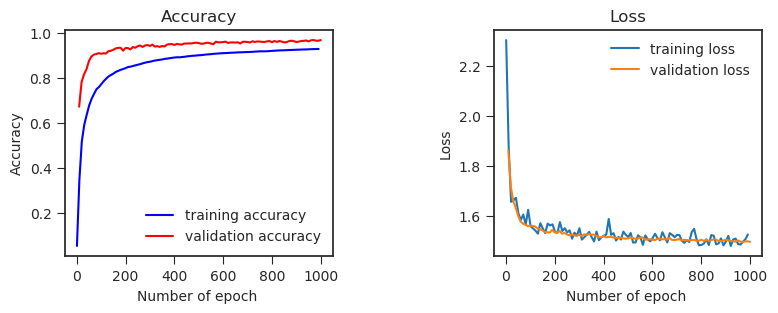

In [577]:
# plot the training loss and accuracy
fig = plt.figure(figsize=(9, 3), dpi=100)
plt.subplots_adjust(wspace=0.6)
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.plot(history_train['accuracy_1'][0], history_train['accuracy_1'][1], 'b', label='training accuracy')
ax1.plot(history_eval['accuracy'][0], history_eval['accuracy'][1], 'r', label='validation accuracy');
ax1.set_title('Accuracy')
ax1.set_xlabel("Number of epoch ")
ax1.set_ylabel("Accuracy")
ax1.legend(loc="best")

ax2.plot(history_train['loss'][0], history_train['loss'][1], label="training loss")
ax2.plot(history_eval['loss'][0], history_eval['loss'][1], label="validation loss")
ax2.set_title("Loss")
ax2.set_xlabel("Number of epoch ")
ax2.set_ylabel("Loss")
ax2.legend(loc="best");

print('Loss:')
print('  - loss [training dataset]: {0:.3f}'.format(history_train['loss'][1][-1]))
print('  - loss [validation dataset: {0:.3f}'.format(history_eval['loss'][1][-1]))
print('')
print('Accuracy:')
print('  - accuracy [training dataset]: {:.2f}%'.format(100 * history_train['accuracy_1'][1][-1]))
print('  - accuracy [validation dataset: {:.2f}%'.format(100 * history_eval['accuracy'][1][-1]))

### Check the output created during the training
https://medium.com/@prasadpal107/saving-freezing-optimizing-for-inference-restoring-of-tensorflow-models-b4146deb21b5  
- creating a keras model will create the **keras** folder 
- **checkpoint**, text file that contain all checkpoint information, like model ckpt file name and path
- **model.ckpt-xxx.meta** and **model.ckpt-xxx.data-yyyyy-of-zzzzz** and **model.ckpt-xxx.index** file created for each model  
  .ckpt-xxx.meta contains the complete graph. It includes GraphDef, SaverDef, and so on  
  .ckpt-xxx.data contains the values of variables(weights, biases, placeholders, gradients, hyper-parameters etc)   
  .ckpt-xxx.index is a table where each key is the name of a tensor and its value is a serialized BundleEntryProto 
- **graph.pbtxt** holds a network of nodes, each representing one operation, connected to each other as inputs and outputs (graph structure)
- **events.out.tfevents.xxxxxxxxxx** which contain information that TensorBoard uses to create visualizations

Meta files holds ,more than just the structure of the graph like MetaInfoDef , GraphDef SaverDef , CollectionDef . Whereas .pbtxt files holds only the structure of the graph.

In [100]:
for file in glob.glob(FLAGS.model_dir+'*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

keras
checkpoint
model.ckpt-940.data-00000-of-00001
model.ckpt-1000.data-00000-of-00001
model.ckpt-920.meta
model.ckpt-940.meta
model.ckpt-1000.meta
model.ckpt-960.meta
events.out.tfevents.1552739145.Fabien-Tarrades-MacBook-Pro.local
graph.pbtxt
model.ckpt-980.meta
model.ckpt-960.data-00000-of-00001
model.ckpt-920.index
model.ckpt-920.data-00000-of-00001
eval
model.ckpt-980.data-00000-of-00001
export
model.ckpt-960.index
model.ckpt-980.index
model.ckpt-940.index
model.ckpt-1000.index


### TensorBoard

In [39]:
print('Tensorflow logs will be saved here:\n',FLAGS.model_dir)

Tensorflow logs will be saved here:
 results/Models/Mnist/tf_1_12/estimator/ckpt/


In [243]:
for file in glob.glob(FLAGS.model_dir+'*events.out.tfevents.*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

events.out.tfevents.1553024123.Fabien-Tarrades-MacBook-Pro.local


In [228]:
tensorboard_command='tensorboard --logdir "'+FLAGS.model_dir+'"'

In [42]:
print('In a separate shell with the same env activated (need Tensoflow and TensorBoard)')
print('  copy and pate the command below without ">>":')
print('  >>',tensorboard_command)


In a separate shell with the same env activated (need Tensoflow and TensorBoard)
  copy and pate the command below without ">>":
  >> tensorboard --logdir "results/Models/Mnist/tf_1_12/estimator/ckpt/"


### Looking at the output of the TimeHistory

In [ ]:
total_time = sum(time_hist.times)
print(f"total time with the current strategy: {total_time} seconds")

In [ ]:
avg_time_per_batch = np.mean(time_hist.times)
print(f"{BATCH_SIZE/avg_time_per_batch} images/second")

## Accuracy and losses

### Training dataset

In [ ]:
score=estimator_train_model.evaluate(input_fn=lambda:mnist_v1.input_mnist_tfrecord_dataset_fn(glob.glob(path_train_tfrecords+'/train*.tfrecords'),
                                                                                              FLAGS,
                                                                                              mode=tf.estimator.ModeKeys.TRAIN,
                                                                                              batch_size=FLAGS.batch_size),
                                     steps=1)

In [ ]:
# print test accuracy
print('Loss:')
print('  - loss [training dataset]: {0:.3f}'.format(score['loss']))
print('')
print('Accuracy:')
print('  - accuracy [training dataset]: {:.2f}%'.format(100*score['accuracy']))
print('')
print('Number of steps:')
print('  - number of steps [training dataset]: {}'.format(score['global_step']))

### Testing dataset

In [ ]:
score=estimator_train_model.evaluate(input_fn=lambda:mnist_v1.input_mnist_tfrecord_dataset_fn(glob.glob(path_test_tfrecords+'/test*.tfrecords'),
                                                                                              FLAGS,
                                                                                              mode=tf.estimator.ModeKeys.EVAL,
                                                                                              batch_size=FLAGS.batch_size),
                                     steps=1)

In [ ]:
# print test accuracy
print('Loss:')
print('  - loss [testing dataset]: {0:.3f}'.format(score['loss']))
print('')
print('Accuracy:')
print('  - accuracy [testing dataset]: {:.2f}%'.format(100*score['accuracy']))
print('')
print('Number of steps:')
print('  - number of steps [testing dataset]: {}'.format(score['global_step']))

## Test

In [ ]:
# Rebuild the model
predictions = model_fn(features, labels, tf.estimator.ModeKeys.EVAL).predictions

# Manually load the latest checkpoint
saver = tf.train.Saver()
with tf.Session() as sess:
    ckpt = tf.train.get_checkpoint_state('/my/directory')
    saver.restore(sess, ckpt.model_checkpoint_path)

    # Loop through the batches and store predictions and labels
    prediction_values = []
    label_values = []
    while True:
        try:
            preds, lbls = sess.run([predictions, labels])
            prediction_values += preds
            label_values += lbls
        except tf.errors.OutOfRangeError:
            break
    # store prediction_values and label_values somewhere

## Prediction 

### Method 1

In [ ]:
testing_dataset = mnist_v1.input_mnist_tfrecord_dataset_fn(sorted(glob.glob(path_test_tfrecords+'/test*.tfrecords'), key=os.path.getmtime),
                                                           FLAGS,
                                                           mode=tf.estimator.ModeKeys.EVAL)

In [ ]:
iterator = testing_dataset.make_one_shot_iterator()
# next_element
features, labels = iterator.get_next()

In [ ]:
n=0

n_iter=10
with tf.Session() as sess:
    while True:
        try:
            start_time = time.clock()
            x,y = sess.run([features, labels])
            print('iteration n:', n, 'execution time:', time.clock() - start_time, 'seconds')
            print(x.shape)
            print(y.shape)
            print('first label of the batch',np.argmax(y[0]),'\n')
            n+=1
            if n>=n_iter:
                print('number of iteration reached')
                break
        except tf.errors.OutOfRangeError:
            print('tf.errors.OutOfRangeError')
            break

In [ ]:
predictions=list(estimator_train_model.predict(input_fn=lambda:mnist_v1.input_mnist_tfrecord_dataset_fn(sorted(glob.glob(path_test_tfrecords+'/test*.tfrecords'), key=os.path.getmtime),
                                                                                                  FLAGS,
                                                                                                  mode=tf.estimator.ModeKeys.PREDICT)))

In [ ]:
len(predictions), len(x_test)

In [ ]:
output_layer=model_opt_tf.output_names[0]

In [ ]:
for i in range(10):
    prediction_array = predictions[i][output_layer]
    predicted_label = np.argmax(prediction_array)
    print('Actual label:', y_test[i])
    print("Predicted label: ", predicted_label)

### Method 2

In [ ]:
preds_iter=estimator_train_model.predict(input_fn=lambda:mnist_v1.input_mnist_tfrecord_dataset_fn(sorted(glob.glob(path_test_tfrecords+'/test*.tfrecords'), key=os.path.getmtime),
                                                                                                  FLAGS,
                                                                                                  mode=tf.estimator.ModeKeys.EVAL,
                                                                                                  batch_size=len(x_test)))

In [ ]:
i=0
for pred in list(itertools.islice(preds_iter, 5)):
    prediction_array = pred['dense_2']
    predicted_label = np.argmax(prediction_array)
    print(prediction_array)
    print(i)
    if i==0:
        print('--> ',pred.keys())
    print()
    print('Actual label:', y_test[i])
    print("Predicted label: ", predicted_label)
    i+=1

### Keras's model checks

In [ ]:
model_opt_tf.summary()

In [ ]:
model_opt_tf.input_names

In [ ]:
model_opt_tf.output_names

In [ ]:
output_layer=model_opt_tf.output_names[0]

### Estimator's model checks

In [ ]:
estimator_train_model.get_variable_names()

In [ ]:
estimator_train_model.get_variable_value(estimator_train_model.get_variable_names()[0]).shape

In [ ]:
estimator_train_model.get_variable_value(estimator_train_model.get_variable_names()[1]).shape

In [ ]:
estimator_train_model.latest_checkpoint()

## Model serving using Keras, tf.estimator and tf.data.dataset

In [ ]:
for file in glob.glob(FLAGS.saved_dir+'*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

In [ ]:
shutil.rmtree(FLAGS.saved_dir, ignore_errors=True)

In [ ]:
model_opt_tf.input_names

In [ ]:
def serving_input_receiver_fn():
    """Serving input_fn that builds features from placeholders#

    Returns
    -------
    tf.estimator.export.ServingInputReceiver
    """
    input_images = tf.placeholder(tf.float32, [None, 784])
    features = {'dense_2_input' : input_images} # this is the dict that is then passed as "features" parameter to your model_fn
    receiver_tensors = {'dense_2_input': input_images} # As far as I understand this is needed to map the input to a name you can retrieve later
   
    return tf.estimator.export.ServingInputReceiver(features, receiver_tensors)

In [ ]:
if not os.path.exists(FLAGS.saved_dir):
    os.makedirs(FLAGS.saved_dir)

In [ ]:
# Option 2: Only export predict mode
estimator_train_model.export_saved_model(os.path.abspath(FLAGS.saved_dir), 
                                         serving_input_receiver_fn=serving_input_receiver_fn)

In [495]:
for file in glob.glob(FLAGS.saved_dir+'*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

**Update the model id in the path below with the correct one from above i.e'1549040172'**

In [504]:
model_tag='1549054852'
os.environ['MODEL_FOR_SERVING']='results/Models/Mnist/tf_1_12/estimator/ckpt/export/exporter/1553112141'#FLAGS.saved_dir+model_tag+'/'

In [502]:
!ls results/Models/Mnist/tf_1_12/estimator/ckpt/export/exporter/1553112141

saved_model.pb variables


In [ ]:
# replace the folder name below with the one from above i.e '1549040172'
for file in glob.glob(FLAGS.saved_dir+model_tag+'/*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

## Check the saved model before serving 

In [493]:
tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY,

('serving_default',)

In [505]:
! saved_model_cli show --dir $MODEL_FOR_SERVING --tag serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['dense_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 784)
      name: Placeholder:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['classes'] tensor_info:
      dtype: DT_INT64
      shape: (-1)
      name: ArgMax:0
  outputs['probabilities'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 10)
      name: Softmax:0
Method name is: tensorflow/serving/predict


## Use Cloud ML Engine

### Checking gcloud installation (SDK)

In [ ]:
os.environ['CLOUDSDK_PYTHON']='/Users/tarrade/anaconda3/bin/python'

### Create a input json file and string

Input needed to get prediction using ml-engine an option --json-instances: 'dense_2_input' for each new entry

In [ ]:
input_prediction=x_test[0:3]

In [ ]:
data = input_prediction.tolist()
json_file = "../data/input_predict_gcloud.json" 

with codecs.open(json_file, 'w', encoding='utf-8') as f:
    for el in data:
        instance = {'dense_2_input': el}
        json.dump(instance, f , sort_keys=True)
        f.write("\n")

Input needed to get prediction using ml-engine and cURL

In [ ]:
data = input_prediction.tolist()
json_file = "../data/input_predict_cURL.json" 

with codecs.open(json_file, 'w', encoding='utf-8') as f:
    tmp={}
    list_tmp=[]
    for el in data:
        tmp['dense_2_input']=el
        list_tmp.append(tmp)
    instance = {"instances": list_tmp}    
    json.dump(instance, f , sort_keys=True)
    f.write("\n")

In [ ]:
input_predict_request = json.dumps({"signature_name": "serving_default", "instances": input_prediction.tolist()})

display example

In [ ]:
def show(img, title):
    plt.figure()
    plt.imshow(img.reshape(28,28))
    plt.axis('off')
    plt.title('\n\n{}'.format(title), fontdict={'size': 16})

In [ ]:
for i in range(1):
    show(x_test[i],'Test dataset, true label: '+str(np.argmax(y_test[i])))

### Test the model inference using gcloud locally

In [ ]:
os.environ['CLOUDSDK_PYTHON']='/Users/tarrade/anaconda3/bin/python'

In [ ]:
!gcloud ml-engine local predict --model-dir $MODEL_FOR_SERVING --json-instances ../data/input_predict_gcloud.json 

### Deploy the model using Cloud ML Engine
- https://cloud.google.com/ml-engine/docs/v1/predict-request
- https://cloud.google.com/ml-engine/docs/tensorflow/online-predict#requesting_predictions

In [ ]:
os.environ['PROJECT']=subprocess.run('gcloud config list project --format "value(core.project)"', shell=True, check=True, stdout=subprocess.PIPE).stdout.decode().replace('\n', '')
os.environ['MODEL']='mnist'
os.environ['BUCKET']='gs://'+os.environ['PROJECT']
os.environ['VERSION']='v2'

In [ ]:
# gsutil need python 2.7
os.environ['CLOUDSDK_PYTHON']='/Users/tarrade/anaconda/bin/python'

In [ ]:
!gsutil cp -r $MODEL_FOR_SERVING $BUCKET/model_dir_tmp/

In [ ]:
!gcloud ml-engine models list

when creating the model for the first time

create a version and store the model

In [ ]:
!gcloud ml-engine versions create ${VERSION} \
--model ${MODEL} \
--origin=${BUCKET}/model_dir_tmp/1549054852 \
--runtime-version=1.12 \
--staging-bucket=${BUCKET}

#### Checking the list of model in ML-Engine

In [ ]:
!gcloud ml-engine models list

In [ ]:
 !gcloud ml-engine versions list --model mnist

#### Testing our model using ML-Engine

In [ ]:
!gcloud ml-engine predict --model=${MODEL} --version=${VERSION} --json-instances ../data/input_predict_gcloud.json

#### Testing using RESTful API 
- https://www.tensorflow.org/serving/api_rest  
RESTful API is an application program interface (API) that uses HTTP requests to GET, PUT, POST and DELETE data (Json)

Use cURL

In [ ]:
!curl https://ml.googleapis.com/v1/projects/${PROJECT}/models/${MODEL}/versions/${VERSION} \
-H "Authorization: Bearer $(gcloud auth print-access-token)" \

In [ ]:
!curl -X POST \
https://ml.googleapis.com/v1/projects/${PROJECT}/models/${MODEL}/versions/${VERSION}:predict \
-H "Content-Type: application/json" \
-H "Authorization: Bearer $(gcloud auth print-access-token)" \
-d @../data/input_predict_cURL.json 

Use python and requests

In [ ]:
url = 'https://ml.googleapis.com/v1/projects/'+os.environ['PROJECT']+'/models/'+os.environ['MODEL']+'/versions/'+os.environ['VERSION']+':predict'

headers = {
    'Content-Type': 'application/json',
    'Authorization':  'Bearer {}'.format(subprocess.run('gcloud auth print-access-token', shell=True, check=True, stdout=subprocess.PIPE).stdout.decode().replace('\n', ''))
}

json_response = requests.post(url=url, data=input_predict_request, headers=headers)
json.loads(json_response.text)

In [ ]:
predictions = json.loads(json_response.text)['predictions']

In [ ]:
for i in range(0,3):
    show(x_test[i], 'The model thought this was a {} , and it was actually a {}'.format(np.argmax(predictions[i]['dense_3']),np.argmax(y_test[i])))

#### Testing using gRPC API 
- https://cloud.google.com/endpoints/docs/grpc/about-grpc  
gRPC is a high performance, open-source universal RPC framework, developed by Google. In gRPC, a client application can directly call methods on a server application on a different machine as if it was a local object, making it easier to create distributed applications and services (Protobuf)

In [ ]:
# to do

## Debug Python environment

In [ ]:
!python -c "import tensorflow as tf; print(tf.GIT_VERSION, tf.VERSION)"

In [ ]:
!conda list

In [ ]:
## Reload the model and make evaluation using Keras

In [ ]:
reload_model_opt_keras=tf.keras.models.load_model(FLAGS.model_dir_keras+'keras_model.h5')

In [ ]:
score = reload_model_opt_keras.evaluate(x_train, 
                                        y_train, 
                                        verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

In [ ]:
### Evaluate the model using Keras and tf.data.dataset

In [ ]:
score = model_opt_keras.evaluate(x_test, 
                       y_test, 
                       verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
score = model_opt_keras.evaluate(x_train, 
                       y_train, 
                       verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

In [ ]:
for i in range(0,3):
    show(x_test[i], 'The model thought this was a {} , and it was actually a {}'.format(np.argmax(predictions[i]['dense_3']),np.argmax(y_test[i])))